In [1]:
import os
import pandas as pd

def extract_flaw_data(source_dir, output_dir):
    """
    Recursively finds 'flawed_papers_global_summary.csv' files in a source
    directory, extracts specific columns, and saves them to a new CSV in a
    mirrored directory structure.

    Args:
        source_dir (str): The path to the root directory to search in (e.g., './data').
        output_dir (str): The path to the root directory where extracted files will be saved.
    """
    # Define the columns to extract from the CSV files.
    columns_to_extract = ['openreview_id', 'flaw_id', 'flaw_description']
    
    # Check if the source directory exists.
    if not os.path.isdir(source_dir):
        print(f"Error: Source directory not found at '{source_dir}'")
        return

    print(f"Starting extraction from '{source_dir}'...")
    print(f"Output will be saved to '{output_dir}'...")

    # os.walk recursively traverses the directory tree.
    # root: current folder path
    # dirs: list of subfolders in the current root
    # files: list of files in the current root
    for root, dirs, files in os.walk(source_dir):
        # Check if our target CSV file is in the current directory.
        if 'flawed_papers_global_summary.csv' in files:
            
            # Construct the full path to the source CSV file.
            source_file_path = os.path.join(root, 'flawed_papers_global_summary.csv')
            print(f"\nFound file: {source_file_path}")

            try:
                # Read the source CSV into a pandas DataFrame.
                df = pd.read_csv(source_file_path)

                # Check if all required columns exist in the DataFrame.
                if all(col in df.columns for col in columns_to_extract):
                    # Select only the columns we need.
                    extracted_df = df[columns_to_extract]

                    # --- Create the mirrored output directory structure ---
                    # Get the relative path from the source_dir to the current file's directory.
                    relative_path = os.path.relpath(root, source_dir)
                    # Create the full path for the output directory.
                    current_output_dir = os.path.join(output_dir, relative_path)
                    
                    # Create the output directory if it doesn't exist.
                    # exist_ok=True prevents an error if the directory is already there.
                    os.makedirs(current_output_dir, exist_ok=True)

                    # Construct the full path for the new output CSV file.
                    # We'll give it a more specific name.
                    output_file_path = os.path.join(current_output_dir, 'extracted_flaw_summary.csv')

                    # Save the extracted data to the new CSV file.
                    extracted_df.to_csv(output_file_path, index=False)
                    print(f"Successfully extracted data to: {output_file_path}")

                else:
                    # Handle cases where the CSV doesn't have the required columns.
                    print(f"Warning: Skipping file {source_file_path} because it's missing one or more required columns.")

            except Exception as e:
                # Handle potential errors during file reading or processing.
                print(f"Error processing file {source_file_path}: {e}")

    print("\nExtraction complete.")


if __name__ == '__main__':
    # --- Configuration ---
    # Set the path to your main 'data' folder.
    source_directory = '../data' 
    
    # Set the name for the new folder where results will be saved.
    output_directory = './extracted_data'

    # Run the extraction function.
    extract_flaw_data(source_directory, output_directory)


Starting extraction from '../data'...
Output will be saved to './extracted_data'...

Found file: ../data/flawed_papers/NeurIPS2024_latest_flawed_papers_v1/flawed_papers_global_summary.csv
Successfully extracted data to: ./extracted_data/flawed_papers/NeurIPS2024_latest_flawed_papers_v1/extracted_flaw_summary.csv

Found file: ../data/flawed_papers/ICLR2025_latest_flawed_papers_v1/flawed_papers_global_summary.csv
Successfully extracted data to: ./extracted_data/flawed_papers/ICLR2025_latest_flawed_papers_v1/extracted_flaw_summary.csv

Found file: ../data/flawed_papers/NeurIPS2023_latest_flawed_papers_v1/flawed_papers_global_summary.csv
Successfully extracted data to: ./extracted_data/flawed_papers/NeurIPS2023_latest_flawed_papers_v1/extracted_flaw_summary.csv

Found file: ../data/flawed_papers/ICML2025_latest_flawed_papers_v1/flawed_papers_global_summary.csv
Successfully extracted data to: ./extracted_data/flawed_papers/ICML2025_latest_flawed_papers_v1/extracted_flaw_summary.csv

Found f

/var/folders/91/2fbkbbgj7471rgv8k0yy0sn40000gn/T/ipykernel_34010/2081804340.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


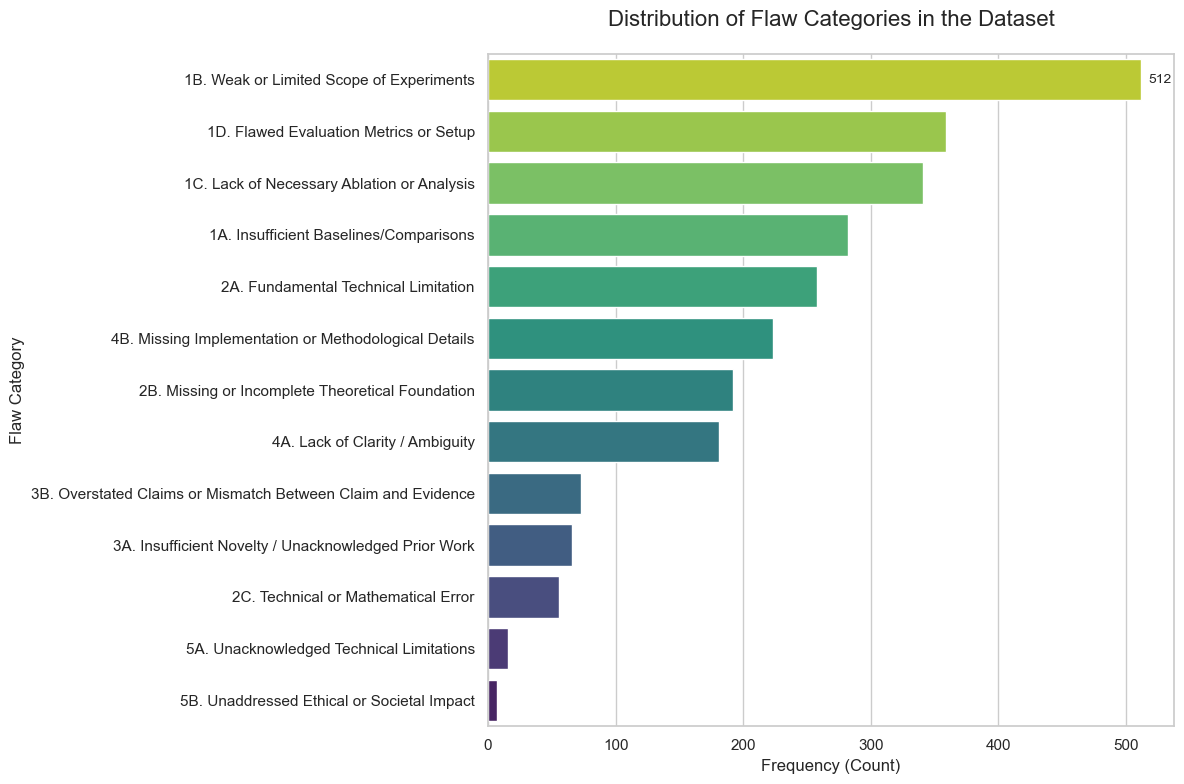

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
import numpy as np
from collections import Counter

# --- Flaw Category Definitions ---
# This dictionary maps the short category IDs to their full descriptions.
category_map = {
    # Category 1: Empirical Evaluation Flaws
    '1a': '1A. Insufficient Baselines/Comparisons',
    '1b': '1B. Weak or Limited Scope of Experiments',
    '1c': '1C. Lack of Necessary Ablation or Analysis',
    '1d': '1D. Flawed Evaluation Metrics or Setup',
    # Category 2: Methodological & Theoretical Flaws
    '2a': '2A. Fundamental Technical Limitation',
    '2b': '2B. Missing or Incomplete Theoretical Foundation',
    '2c': '2C. Technical or Mathematical Error',
    # Category 3: Positioning & Contribution Flaws
    '3a': '3A. Insufficient Novelty / Unacknowledged Prior Work',
    '3b': '3B. Overstated Claims or Mismatch Between Claim and Evidence',
    # Category 4: Presentation & Reproducibility Flaws
    '4a': '4A. Lack of Clarity / Ambiguity',
    '4b': '4B. Missing Implementation or Methodological Details',
    # Category 5: Failure to Address Limitations or Ethical Concerns
    '5a': '5A. Unacknowledged Technical Limitations',
    '5b': '5B. Unaddressed Ethical or Societal Impact'
}

# --- Data Loading and Preparation ---


file_path = "./extracted_data/flawed_papers/ICLR2024_latest_flawed_papers_v1/categorized_flaw.csv"
df = pd.read_csv(file_path)


# --- Data Processing ---

# Drop rows where 'category_ids' is missing, as they cannot be plotted.
df.dropna(subset=['category_ids'], inplace=True)

# The 'category_ids' column can contain multiple comma-separated IDs.
# 1. Split the strings by the comma.
# 2. Use 'explode' to give each ID its own row.
# 3. Use 'str.strip()' to remove any extra whitespace (e.g., from "3b, 2b").
all_categories = df['category_ids'].str.split(',').explode().str.strip() # <<< FIX

# Count the frequency of each unique category ID.
category_counts = Counter(all_categories)

# Convert the counter to a more usable DataFrame.
counts_df = pd.DataFrame(category_counts.items(), columns=['category_id', 'count'])

# Map the short category IDs to their full, descriptive names for the plot.
counts_df['description'] = counts_df['category_id'].map(category_map)

# Sort the DataFrame by the count in descending order for a clearer plot.
counts_df.sort_values('count', ascending=False, inplace=True)


# --- Plotting ---

# Set the style for the plot.
sns.set_theme(style="whitegrid")

# Create the figure and axes. A larger figure size helps with readability.
plt.figure(figsize=(12, 8))

# Create the horizontal bar plot.
# Using a color palette can make it more visually appealing.
ax = sns.barplot(
    x='count',
    y='description',
    data=counts_df,
    orient='h',
    palette='viridis_r' # Using a reversed viridis color map
)

# Set the labels and title for clarity.
ax.set_xlabel('Frequency (Count)', fontsize=12)
ax.set_ylabel('Flaw Category', fontsize=12)
ax.set_title('Distribution of Flaw Categories in the Dataset', fontsize=16, pad=20)

# Add the exact count as a label at the end of each bar.
# This makes the plot easier to read without referring to the x-axis constantly.
ax.bar_label(ax.containers[0], padding=5, fontsize=10)

# Adjust plot margins to ensure everything fits.
plt.tight_layout()

# Display the plot.
plt.show()

Successfully loaded 2421 flaw category mappings.
Scanning for ICLR2024 data in: /Users/ktgiahieu/Documents/review-assistant/data/metareviews

--- FDR Results by Flaw Category (ICLR 2024) ---
                                                         FDR
model                                  category_id          
Llama-4-Maverick-17B-128E-Instruct-FP8 1b           0.434442
                                       2b           0.340314
                                       1a           0.221429
                                       2a           0.539062
                                       1d           0.215084
...                                                      ...
o1-2024-12-17                          3a           0.151515
                                       4a           0.154696
                                       5b           0.571429
                                       2c           0.053571
                                       5a           0.437500

[65 rows x 1 co

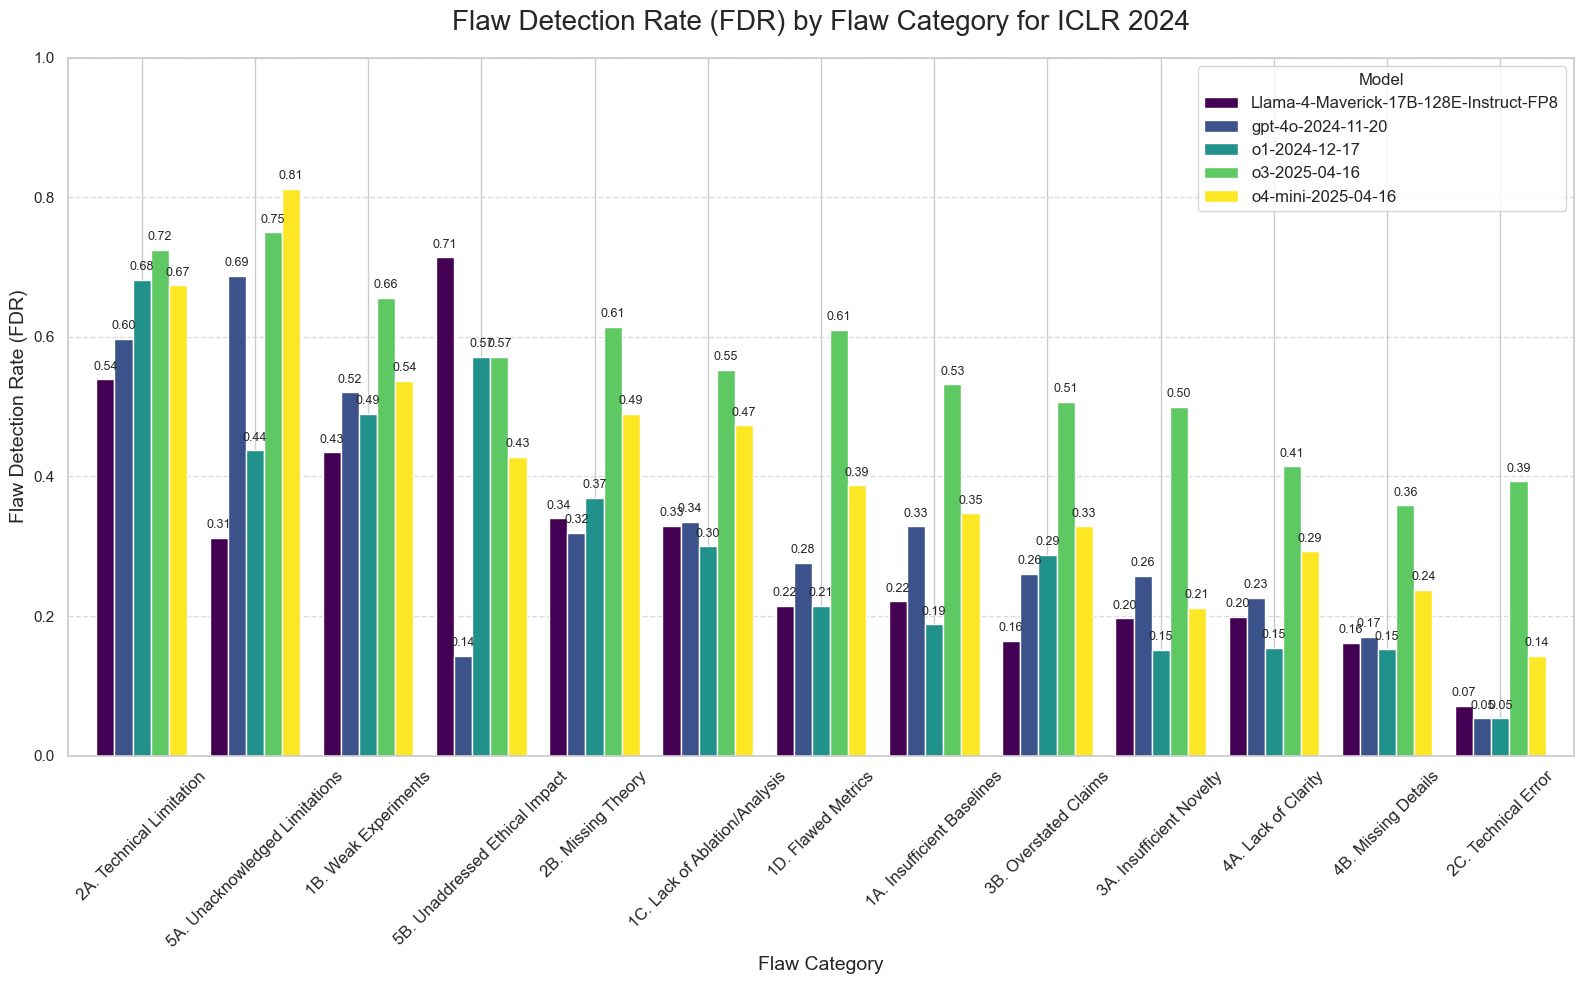

In [4]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import defaultdict

# --- Flaw Category Definitions ---
# This dictionary maps the short category IDs to their full descriptions.
category_map = {
    '1a': '1A. Insufficient Baselines',
    '1b': '1B. Weak Experiments',
    '1c': '1C. Lack of Ablation/Analysis',
    '1d': '1D. Flawed Metrics',
    '2a': '2A. Technical Limitation',
    '2b': '2B. Missing Theory',
    '2c': '2C. Technical Error',
    '3a': '3A. Insufficient Novelty',
    '3b': '3B. Overstated Claims',
    '4a': '4A. Lack of Clarity',
    '4b': '4B. Missing Details',
    '5a': '5A. Unacknowledged Limitations',
    '5b': '5B. Unaddressed Ethical Impact'
}

def load_data_from_file(filepath):
    """Loads JSON data from a single file."""
    try:
        with open(filepath, 'r') as f:
            return json.load(f)
    except (FileNotFoundError, json.JSONDecodeError) as e:
        print(f"Error reading or parsing {filepath}: {e}")
        return None

def load_flaw_categories(filepath):
    """
    Loads the CSV file with flaw categories and creates a lookup dictionary.
    The dictionary maps (openreview_id, flaw_id) to a comma-separated string
    of category_ids, which is essential for merging data sources.
    """
    try:
        df = pd.read_csv(filepath)
        # Ensure required columns exist
        if not {'openreview_id', 'flaw_id', 'category_ids'}.issubset(df.columns):
            print(f"Error: The category file at {filepath} is missing required columns.")
            return None
        # Create a tuple of (openreview_id, flaw_id) to be the key
        df.set_index(['openreview_id', 'flaw_id'], inplace=True)
        # Convert the 'category_ids' column to a dictionary for fast lookups
        category_lookup = df['category_ids'].to_dict()
        print(f"Successfully loaded {len(category_lookup)} flaw category mappings.")
        return category_lookup
    except FileNotFoundError:
        print(f"Error: Flaw category file not found at {filepath}. This file is required.")
        return None


def load_iclr2024_data(base_path):
    """
    Scans the directory structure to find and load all JSON files for the ICLR2024 venue,
    categorizing them by the generating LLM.
    """
    structured_data = []
    base_path_abs = os.path.abspath(base_path)
    print(f"Scanning for ICLR2024 data in: {base_path_abs}")

    if not os.path.exists(base_path):
        print(f"Warning: Base directory not found at {base_path_abs}")
        return []

    for model_name in os.listdir(base_path):
        model_path = os.path.join(base_path, model_name)
        if os.path.isdir(model_path):
            # Target the specific ICLR2024 directory within each model's folder
            venue_path = os.path.join(model_path, 'ICLR2024_latest_flawed_papers_v1')
            if os.path.isdir(venue_path):
                for status in ['accepted', 'rejected']:
                    status_path = os.path.join(venue_path, status)
                    if os.path.isdir(status_path):
                        for file in os.listdir(status_path):
                            if file.endswith(".json"):
                                filepath = os.path.join(status_path, file)
                                data = load_data_from_file(filepath)
                                if data:
                                    record = {
                                        'model': model_name,
                                        'venue': 'ICLR2024',
                                        'status': status,
                                        'data': data,
                                        'filename': file # Store filename for better debugging
                                    }
                                    structured_data.append(record)

    if not structured_data:
        print("Warning: No ICLR2024 data files were found. Check the BASE_DIRECTORY path and structure.")
    return structured_data

def plot_fdr_by_flaw_type(results_df):
    """
    Plots the Flaw Detection Rate (FDR) for each flaw category, grouped by model.
    """
    if results_df.empty:
        print("No results to plot.")
        return

    # --- Data Preparation for Plotting ---
    # Map category IDs to full descriptions for the plot's x-axis
    results_df['Flaw Category'] = results_df.index.get_level_values('category_id').map(category_map)

    # Pivot the table to have models as columns and categories as the index
    plot_data = results_df.pivot_table(
        index='Flaw Category',
        columns='model',
        values='FDR'
    )
    
    # Sort by the mean FDR across models to make the plot easier to read
    plot_data = plot_data.reindex(plot_data.mean(axis=1).sort_values(ascending=False).index)


    # --- Plotting ---
    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(figsize=(16, 10))

    plot_data.plot(kind='bar', ax=ax, width=0.8, colormap='viridis')

    ax.set_title('Flaw Detection Rate (FDR) by Flaw Category for ICLR 2024', fontsize=20, pad=20)
    ax.set_ylabel('Flaw Detection Rate (FDR)', fontsize=14)
    ax.set_xlabel('Flaw Category', fontsize=14)
    ax.tick_params(axis='x', rotation=45, labelsize=12)
    ax.set_ylim(0, 1)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.legend(title='Model', fontsize=12)

    # Add value labels on top of each bar
    for p in ax.patches:
        if p.get_height() > 0:
            ax.annotate(f"{p.get_height():.2f}",
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center',
                        xytext=(0, 9),
                        textcoords='offset points',
                        fontsize=9)

    plt.tight_layout()
    plt.show()


if __name__ == '__main__':
    # --- Configuration ---
    # Adjust these paths to match your project structure.
    BASE_DIRECTORY = '../data/metareviews'
    # Correct path to the CSV file containing flaw category definitions.
    FLAW_CATEGORY_FILE = './extracted_data/flawed_papers/ICLR2024_latest_flawed_papers_v1/categorized_flaw.csv'

    # 1. Load the flaw category mapping. This is essential.
    category_lookup = load_flaw_categories(FLAW_CATEGORY_FILE)
    if not category_lookup:
        exit() # Stop execution if the category mapping file is not found or invalid.

    # 2. Load all JSON data specifically for ICLR2024
    iclr_data = load_iclr2024_data(BASE_DIRECTORY)

    # 3. Aggregate flaw data by model and flaw category by merging data sources.
    flaw_data_by_category = defaultdict(list)
    
    for record in iclr_data:
        model = record['model']
        # 'record['data']' holds the content of one JSON file, e.g., {'XTHfNGI3zT_2310_01188': [flaw1, ...]}
        for json_paper_key, flaws in record['data'].items():
            if not isinstance(flaws, list): continue
            
            for flaw in flaws:
                # Find the matching openreview_id from the CSV by checking if the JSON key starts with it.
                # This handles the mismatch between 'zNzVhX00h4' and 'zNzVhX00h4_xxxx_xxxx'.
                
                # We iterate through our lookup keys to find a match.
                # This is less efficient but necessary due to the ID mismatch.
                found_match = False
                for (openreview_id, flaw_id) in category_lookup.keys():
                    if json_paper_key.startswith(openreview_id) and flaw_id == flaw.get('flaw_id'):
                        
                        category_ids_str = category_lookup.get((openreview_id, flaw_id))

                        if category_ids_str and isinstance(flaw, dict):
                            # Split and strip to handle cases like "2a, 3b"
                            category_ids = [cat.strip() for cat in str(category_ids_str).split(',')]
                            for cat_id in category_ids:
                                if cat_id: # Ensure not an empty string
                                    # The 'flaw' dict from the JSON has the mention status we need
                                    flaw_data_by_category[(model, cat_id)].append(flaw)
                            found_match = True
                            break # Move to the next flaw once a match is found
                # if not found_match:
                #     print(f"Debug: No category match found for paper key '{json_paper_key}' and flaw_id '{flaw.get('flaw_id')}'")


    # 4. Calculate FDR for each (model, category) group
    fdr_results = {}
    for (model, cat_id), flaw_list in flaw_data_by_category.items():
        total_flaws = len(flaw_list)
        mentions = sum(1 for f in flaw_list if f.get('is_flaw_mentioned'))
        
        fdr = mentions / total_flaws if total_flaws > 0 else 0
        fdr_results[(model, cat_id)] = {'FDR': fdr}

    # 5. Convert results to a DataFrame for easier plotting
    results_df = pd.DataFrame.from_dict(fdr_results, orient='index')
    if not results_df.empty:
        results_df.index = pd.MultiIndex.from_tuples(
            results_df.index, names=['model', 'category_id']
        )
        print("\n--- FDR Results by Flaw Category (ICLR 2024) ---")
        print(results_df)
        print("---------------------------------------------------\n")
        
        # 6. Plot the results
        plot_fdr_by_flaw_type(results_df)
    else:
        print("Processing complete, but no flaw data with matching 'category_ids' could be found.")
        print("Please check that paper_ids in the JSONs have a corresponding prefix in the category CSV.")



Successfully loaded 2421 flaw category mappings.
Scanning for ICLR2024 data in: /Users/ktgiahieu/Documents/review-assistant/data/metareviews

--- Combined Proportional Distributions ---
       Human  Llama-4-Maverick-17B-128E-Instruct-FP8  gpt-4o-2024-11-20  \
2a  0.100546                                0.175349           0.167396   
2b  0.074825                                0.082592           0.066740   
4b  0.086906                                0.045743           0.041575   
1b  0.199532                                0.282084           0.289934   
1c  0.132892                                0.142313           0.124726   
1d  0.139906                                0.097840           0.108315   
1a  0.109899                                0.078780           0.100656   
5b  0.002728                                0.006353           0.001094   
3b  0.028449                                0.015248           0.020788   
2c  0.021824                                0.005083           0

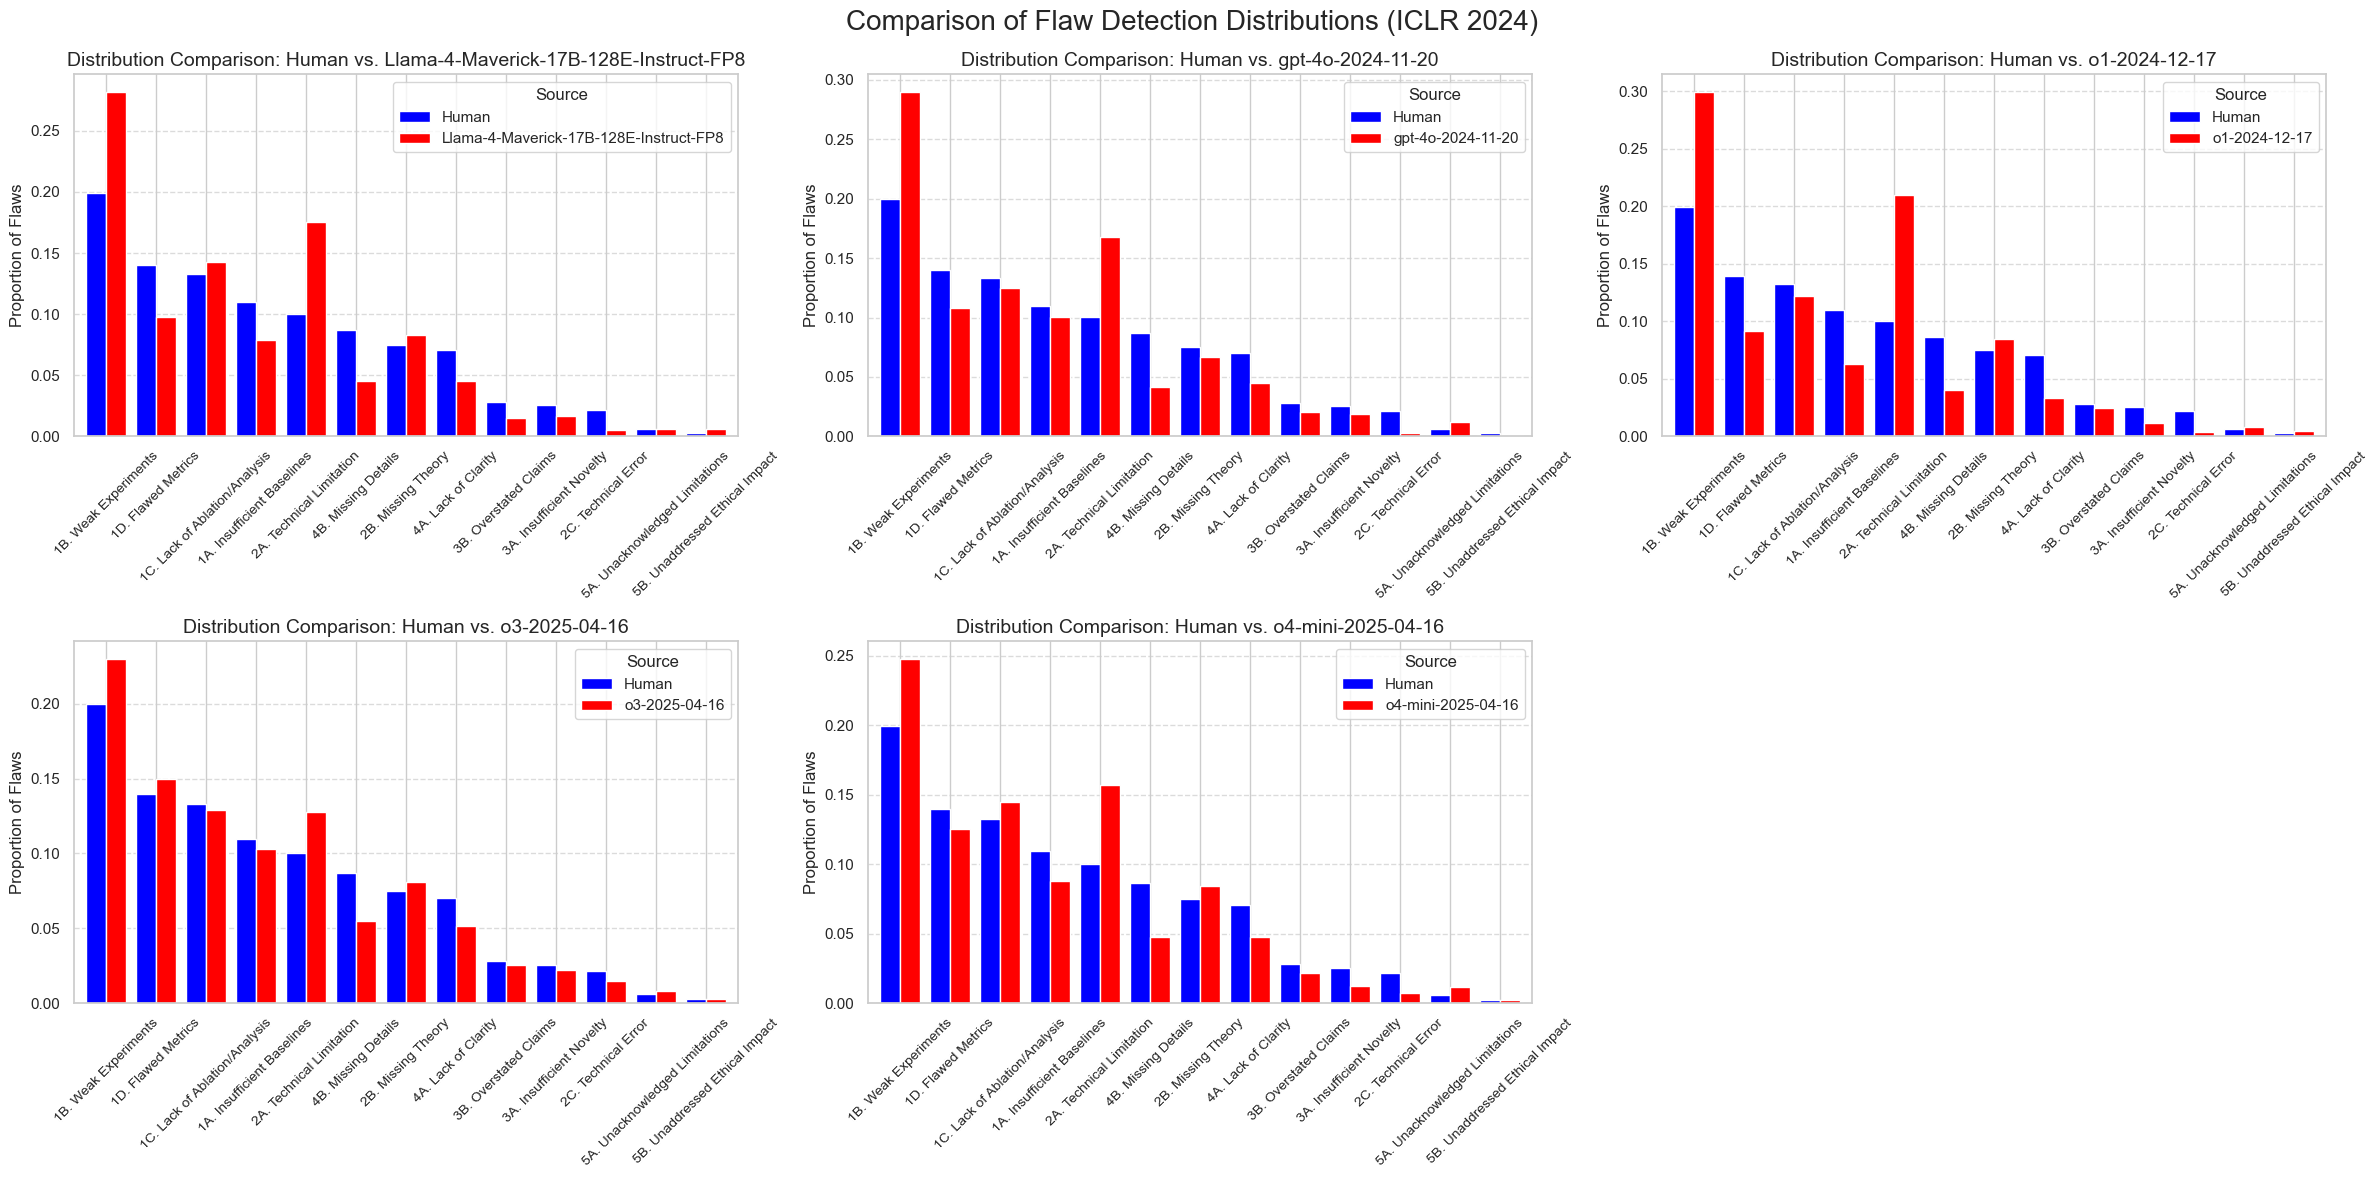

In [6]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import defaultdict, Counter

# --- Flaw Category Definitions ---
# This dictionary maps the short category IDs to their full descriptions.
category_map = {
    '1a': '1A. Insufficient Baselines',
    '1b': '1B. Weak Experiments',
    '1c': '1C. Lack of Ablation/Analysis',
    '1d': '1D. Flawed Metrics',
    '2a': '2A. Technical Limitation',
    '2b': '2B. Missing Theory',
    '2c': '2C. Technical Error',
    '3a': '3A. Insufficient Novelty',
    '3b': '3B. Overstated Claims',
    '4a': '4A. Lack of Clarity',
    '4b': '4B. Missing Details',
    '5a': '5A. Unacknowledged Limitations',
    '5b': '5B. Unaddressed Ethical Impact'
}

def load_data_from_file(filepath):
    """Loads JSON data from a single file."""
    try:
        with open(filepath, 'r') as f:
            return json.load(f)
    except (FileNotFoundError, json.JSONDecodeError) as e:
        print(f"Error reading or parsing {filepath}: {e}")
        return None

def load_flaw_categories(filepath):
    """
    Loads the CSV file with flaw categories and creates a lookup dictionary.
    """
    try:
        df = pd.read_csv(filepath)
        if not {'openreview_id', 'flaw_id', 'category_ids'}.issubset(df.columns):
            print(f"Error: The category file at {filepath} is missing required columns.")
            return None
        df.set_index(['openreview_id', 'flaw_id'], inplace=True)
        category_lookup = df['category_ids'].to_dict()
        print(f"Successfully loaded {len(category_lookup)} flaw category mappings.")
        return category_lookup
    except FileNotFoundError:
        print(f"Error: Flaw category file not found at {filepath}. This file is required.")
        return None

def calculate_human_distribution(filepath):
    """
    Calculates the ground-truth distribution of flaw categories from the CSV.
    """
    try:
        df = pd.read_csv(filepath)
        df.dropna(subset=['category_ids'], inplace=True)
        all_categories = df['category_ids'].str.split(',').explode().str.strip()
        category_counts = Counter(all_categories)
        counts_df = pd.DataFrame(category_counts.items(), columns=['category_id', 'count'])
        # Normalize the counts to get a proportion
        counts_df['distribution'] = counts_df['count'] / counts_df['count'].sum()
        counts_df = counts_df.set_index('category_id')['distribution']
        return counts_df.rename('Human')
    except FileNotFoundError:
        print(f"Error: Could not calculate human distribution. File not found at {filepath}.")
        return None

def load_iclr2024_data(base_path):
    """
    Scans the directory structure to find and load all JSON files for the ICLR2024 venue.
    """
    structured_data = []
    base_path_abs = os.path.abspath(base_path)
    print(f"Scanning for ICLR2024 data in: {base_path_abs}")
    if not os.path.exists(base_path):
        print(f"Warning: Base directory not found at {base_path_abs}")
        return []
    for model_name in os.listdir(base_path):
        model_path = os.path.join(base_path, model_name)
        if os.path.isdir(model_path):
            venue_path = os.path.join(model_path, 'ICLR2024_latest_flawed_papers_v1')
            if os.path.isdir(venue_path):
                for status in ['accepted', 'rejected']:
                    status_path = os.path.join(venue_path, status)
                    if os.path.isdir(status_path):
                        for file in os.listdir(status_path):
                            if file.endswith(".json"):
                                filepath = os.path.join(status_path, file)
                                data = load_data_from_file(filepath)
                                if data:
                                    structured_data.append({
                                        'model': model_name, 'data': data
                                    })
    return structured_data

def plot_distributions_comparison(dist_df):
    """
    For each model, plots its flaw detection distribution against the human ground-truth.
    """
    if dist_df.empty:
        print("No distribution data to plot.")
        return

    models = [col for col in dist_df.columns if col != 'Human']
    num_models = len(models)
    
    # Create a grid of subplots
    # Adjust layout based on number of models for better readability
    if num_models <= 3:
        nrows, ncols = 1, num_models
        figsize = (8 * num_models, 6)
    else:
        nrows = int(np.ceil(num_models / 3))
        ncols = 3
        figsize = (24, 6 * nrows)

    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False)
    ax_flat = axes.flatten()

    # Map category IDs to full descriptions for plot labels
    dist_df.index = dist_df.index.map(category_map)
    dist_df = dist_df.sort_values('Human', ascending=False)

    for i, model in enumerate(models):
        ax = ax_flat[i]
        
        # Select data for the current model and the human baseline
        plot_data = dist_df[['Human', model]]
        
        plot_data.plot(kind='bar', ax=ax, width=0.8, color=['blue', 'red'])
        
        ax.set_title(f'Distribution Comparison: Human vs. {model}', fontsize=14)
        ax.set_ylabel('Proportion of Flaws', fontsize=12)
        ax.set_xlabel('')
        ax.tick_params(axis='x', rotation=45, labelsize=10)
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        ax.legend(title='Source')

    # Hide any unused subplots
    for j in range(i + 1, len(ax_flat)):
        ax_flat[j].set_visible(False)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    fig.suptitle('Comparison of Flaw Detection Distributions (ICLR 2024)', fontsize=20)
    plt.show()


if __name__ == '__main__':
    # --- Configuration ---
    BASE_DIRECTORY = '../data/metareviews'
    FLAW_CATEGORY_FILE = './extracted_data/flawed_papers/ICLR2024_latest_flawed_papers_v1/categorized_flaw.csv'

    # 1. Calculate the ground-truth human distribution of flaws.
    human_distribution = calculate_human_distribution(FLAW_CATEGORY_FILE)
    if human_distribution is None:
        exit()

    # 2. Load flaw category lookup and model-generated review data.
    category_lookup = load_flaw_categories(FLAW_CATEGORY_FILE)
    iclr_data = load_iclr2024_data(BASE_DIRECTORY)
    if not category_lookup or not iclr_data:
        exit()

    # 3. Aggregate detected flaws by model and category.
    detected_flaws_by_category = defaultdict(list)
    for record in iclr_data:
        model = record['model']
        for json_paper_key, flaws in record['data'].items():
            if not isinstance(flaws, list): continue
            for flaw in flaws:
                if not (isinstance(flaw, dict) and flaw.get('is_flaw_mentioned')):
                    continue # Skip if flaw was not mentioned
                
                for (openreview_id, flaw_id), category_ids_str in category_lookup.items():
                    if json_paper_key.startswith(openreview_id) and flaw_id == flaw.get('flaw_id'):
                        category_ids = [cat.strip() for cat in str(category_ids_str).split(',')]
                        for cat_id in category_ids:
                            if cat_id:
                                detected_flaws_by_category[(model, cat_id)].append(flaw)
                        break

    # 4. Calculate the distribution for each model.
    model_distributions = {}
    all_models = sorted(list(set(rec['model'] for rec in iclr_data)))
    for model in all_models:
        model_counts = Counter()
        for (m, cat_id), flaw_list in detected_flaws_by_category.items():
            if m == model:
                model_counts[cat_id] += len(flaw_list)
        
        total_detected = sum(model_counts.values())
        if total_detected > 0:
            dist = {cat_id: count / total_detected for cat_id, count in model_counts.items()}
            model_distributions[model] = pd.Series(dist, name=model)

    # 5. Combine human and model distributions into a single DataFrame.
    if model_distributions:
        combined_df = pd.concat([human_distribution] + list(model_distributions.values()), axis=1)
        combined_df.fillna(0, inplace=True) # Fill NaNs for categories a model didn't find
        
        print("\n--- Combined Proportional Distributions ---")
        print(combined_df)
        print("-----------------------------------------\n")

        # 6. Plot the results.
        plot_distributions_comparison(combined_df)
    else:
        print("Processing complete, but no detected flaws were found to create model distributions.")



Successfully loaded 2421 flaw category mappings.
Scanning for ICLR2024 data in: /Users/ktgiahieu/Documents/review-assistant/data/metareviews

--- Model Flaw Detection Rates (FDR) ---
                                                         FDR
model                                  category_id          
Llama-4-Maverick-17B-128E-Instruct-FP8 2a           0.534884
                                       2b           0.338542
                                       4b           0.161435
                                       1b           0.433594
                                       1c           0.328446
...                                                      ...
o4-mini-2025-04-16                     3b           0.328767
                                       2c           0.142857
                                       4a           0.292818
                                       3a           0.212121
                                       5a           0.812500

[65 rows x 1 columns]
-

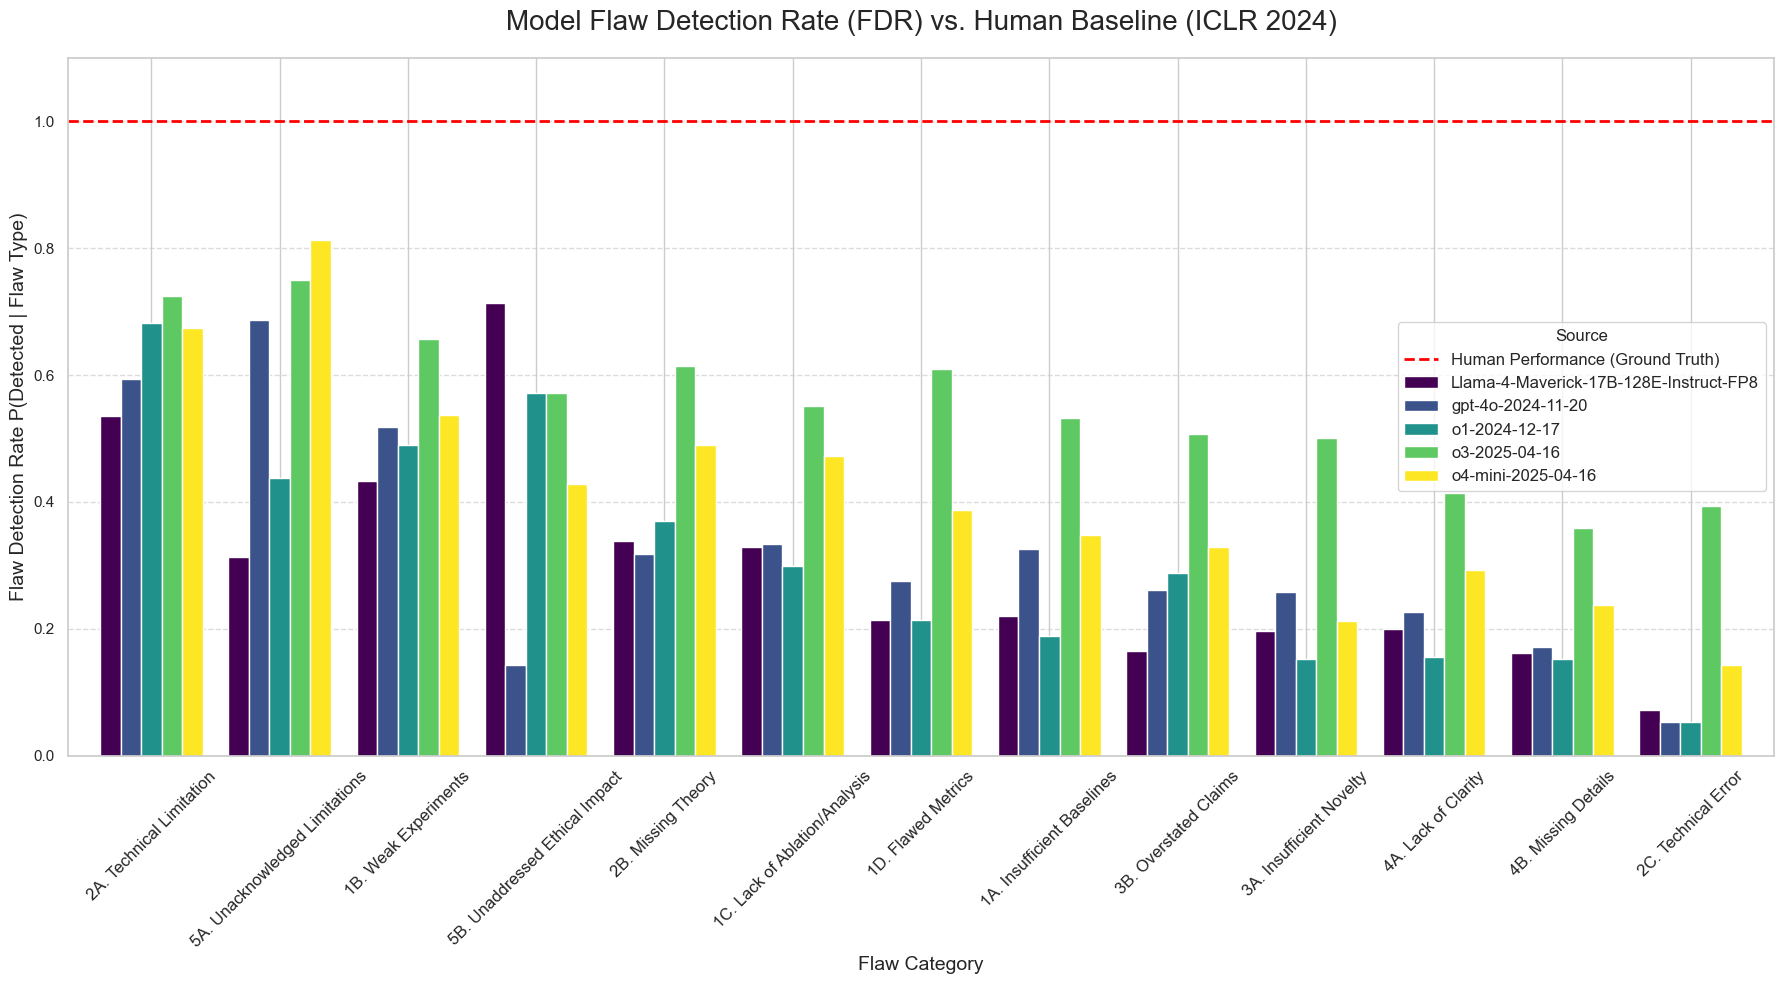

In [8]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import defaultdict, Counter

# --- Flaw Category Definitions ---
# This dictionary maps the short category IDs to their full descriptions.
category_map = {
    '1a': '1A. Insufficient Baselines',
    '1b': '1B. Weak Experiments',
    '1c': '1C. Lack of Ablation/Analysis',
    '1d': '1D. Flawed Metrics',
    '2a': '2A. Technical Limitation',
    '2b': '2B. Missing Theory',
    '2c': '2C. Technical Error',
    '3a': '3A. Insufficient Novelty',
    '3b': '3B. Overstated Claims',
    '4a': '4A. Lack of Clarity',
    '4b': '4B. Missing Details',
    '5a': '5A. Unacknowledged Limitations',
    '5b': '5B. Unaddressed Ethical Impact'
}

def load_data_from_file(filepath):
    """Loads JSON data from a single file."""
    try:
        with open(filepath, 'r') as f:
            return json.load(f)
    except (FileNotFoundError, json.JSONDecodeError) as e:
        print(f"Error reading or parsing {filepath}: {e}")
        return None

def load_flaw_categories(filepath):
    """
    Loads the CSV file with flaw categories and creates a lookup dictionary.
    """
    try:
        df = pd.read_csv(filepath)
        if not {'openreview_id', 'flaw_id', 'category_ids'}.issubset(df.columns):
            print(f"Error: The category file at {filepath} is missing required columns.")
            return None
        df.set_index(['openreview_id', 'flaw_id'], inplace=True)
        category_lookup = df['category_ids'].to_dict()
        print(f"Successfully loaded {len(category_lookup)} flaw category mappings.")
        return category_lookup
    except FileNotFoundError:
        print(f"Error: Flaw category file not found at {filepath}. This file is required.")
        return None

def load_iclr2024_data(base_path):
    """
    Scans the directory structure to find and load all JSON files for the ICLR2024 venue.
    """
    structured_data = []
    base_path_abs = os.path.abspath(base_path)
    print(f"Scanning for ICLR2024 data in: {base_path_abs}")
    if not os.path.exists(base_path):
        print(f"Warning: Base directory not found at {base_path_abs}")
        return []
    for model_name in os.listdir(base_path):
        model_path = os.path.join(base_path, model_name)
        if os.path.isdir(model_path):
            venue_path = os.path.join(model_path, 'ICLR2024_latest_flawed_papers_v1')
            if os.path.isdir(venue_path):
                for status in ['accepted', 'rejected']:
                    status_path = os.path.join(venue_path, status)
                    if os.path.isdir(status_path):
                        for file in os.listdir(status_path):
                            if file.endswith(".json"):
                                filepath = os.path.join(status_path, file)
                                data = load_data_from_file(filepath)
                                if data:
                                    structured_data.append({
                                        'model': model_name, 'data': data
                                    })
    return structured_data

def plot_fdr_vs_human(fdr_df):
    """
    Plots the Flaw Detection Rate (FDR) for each model against the
    human ground-truth baseline (which is 1.0).
    """
    if fdr_df.empty:
        print("No FDR data to plot.")
        return

    # Map category IDs to full descriptions for plot labels
    fdr_df['Flaw Category'] = fdr_df.index.get_level_values('category_id').map(category_map)

    # Pivot the table to have models as columns for grouped bar plotting
    plot_data = fdr_df.pivot_table(
        index='Flaw Category',
        columns='model',
        values='FDR'
    )
    
    # Sort categories by the mean FDR across models for better visualization
    plot_data = plot_data.reindex(plot_data.mean(axis=1).sort_values(ascending=False).index)

    # --- Plotting ---
    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(figsize=(18, 10))

    plot_data.plot(kind='bar', ax=ax, width=0.8, colormap='viridis')

    # Add a horizontal line at y=1.0 for the human baseline
    ax.axhline(1.0, color='red', linestyle='--', linewidth=2, label='Human Performance (Ground Truth)')
    
    ax.set_title('Model Flaw Detection Rate (FDR) vs. Human Baseline (ICLR 2024)', fontsize=20, pad=20)
    ax.set_ylabel('Flaw Detection Rate P(Detected | Flaw Type)', fontsize=14)
    ax.set_xlabel('Flaw Category', fontsize=14)
    ax.tick_params(axis='x', rotation=45, labelsize=12)
    ax.set_ylim(0, 1.1) # Set ylim to give space for the baseline
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Ensure the new baseline label is included in the legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, title='Source', fontsize=12)

    plt.tight_layout()
    plt.show()


if __name__ == '__main__':
    # --- Configuration ---
    BASE_DIRECTORY = '../data/metareviews'
    FLAW_CATEGORY_FILE = './extracted_data/flawed_papers/ICLR2024_latest_flawed_papers_v1/categorized_flaw.csv'

    # 1. Load flaw category lookup and model-generated review data.
    category_lookup = load_flaw_categories(FLAW_CATEGORY_FILE)
    iclr_data = load_iclr2024_data(BASE_DIRECTORY)
    if not category_lookup or not iclr_data:
        exit()

    # 2. Aggregate all flaw instances from the ground truth (CSV)
    #    and from model detections (JSON).
    #    Structure: {(model, category_id): {'detected': count, 'total': count}}
    fdr_data = defaultdict(lambda: defaultdict(int))
    
    # First, count the total number of flaws in each category (ground truth)
    total_flaws_by_category = Counter()
    for category_ids_str in category_lookup.values():
        category_ids = [cat.strip() for cat in str(category_ids_str).split(',')]
        for cat_id in category_ids:
            if cat_id:
                total_flaws_by_category[cat_id] += 1

    # Second, count the number of detected flaws by each model for each category
    for record in iclr_data:
        model = record['model']
        for json_paper_key, flaws in record['data'].items():
            if not isinstance(flaws, list): continue
            for flaw in flaws:
                if not (isinstance(flaw, dict) and flaw.get('is_flaw_mentioned')):
                    continue # Skip if flaw was not mentioned
                
                for (openreview_id, flaw_id), category_ids_str in category_lookup.items():
                    if json_paper_key.startswith(openreview_id) and flaw_id == flaw.get('flaw_id'):
                        category_ids = [cat.strip() for cat in str(category_ids_str).split(',')]
                        for cat_id in category_ids:
                            if cat_id:
                                fdr_data[(model, cat_id)]['detected'] += 1
                        break

    # 3. Calculate the FDR for each model and category.
    fdr_results = {}
    all_models = sorted(list(set(rec['model'] for rec in iclr_data)))
    for model in all_models:
        for cat_id, total in total_flaws_by_category.items():
            detected_count = fdr_data.get((model, cat_id), {}).get('detected', 0)
            fdr = detected_count / total if total > 0 else 0
            fdr_results[(model, cat_id)] = {'FDR': fdr}

    # 4. Convert results to a DataFrame for easier plotting.
    if fdr_results:
        fdr_df = pd.DataFrame.from_dict(fdr_results, orient='index')
        fdr_df.index = pd.MultiIndex.from_tuples(
            fdr_df.index, names=['model', 'category_id']
        )
        
        print("\n--- Model Flaw Detection Rates (FDR) ---")
        print(fdr_df)
        print("----------------------------------------\n")

        # 5. Plot the results.
        plot_fdr_vs_human(fdr_df)
    else:
        print("Processing complete, but no detected flaws were found to calculate FDR.")

